# Import Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
df_original = pd.read_csv('hmeq.csv')

In [3]:
df = df_original.copy()

# Inspect Data

In [4]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [5]:
df.shape

(5960, 13)

In [6]:
df.dtypes

BAD          int64
LOAN         int64
MORTDUE    float64
VALUE      float64
REASON      object
JOB         object
YOJ        float64
DEROG      float64
DELINQ     float64
CLAGE      float64
NINQ       float64
CLNO       float64
DEBTINC    float64
dtype: object

In [7]:
df.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


# Handle Missing Values

| Imputation Type | Target Columns | Rationale |
|-----------------|----------------|-----------|
| Missing Flags | YOJ, DEROG, DELINQ, CLAGE, NINQ, CLNO, DEBTINC | Leverages the information contained in the missingness itself. When missing values are potentially informative (MNAR: Missing Not At Random), adding a separate binary flag allows the model to learn from the fact that a value is missing. |
| Categorical Imputation | REASON, JOB | Preserves missing information by treating missing values as an independent category (“Unknown”). This helps the model utilize the signal contained in the fact that these values are missing. |
| Median Imputation | LOAN, MORTDUE, VALUE, CLAGE, CLNO, DEBTINC | Provides robustness to outliers. Financial variables often have skewed distributions with extreme values, and using the median prevents distortion of the data caused by those outliers. |
| Zero Imputation | YOJ, DEROG, DELINQ, NINQ | Aligns with the semantic meaning of the variables. These columns often represent counts or durations, and interpreting missing values as zero (e.g., “no history,” “zero occurrences”) is logically consistent. |


In [8]:
df.isnull().sum()

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

In [9]:
## --- 1. Create Missing Flags ---
# Columns requiring a missing flag: YOJ, DEROG, DELINQ, CLAGE, NINQ, CLNO, DEBTINC
flag_cols = ['YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

for col in flag_cols:
    # Create a flag column: 1 if missing (null), 0 otherwise
    df[f'{col}_MISSING'] = df[col].isnull().astype(int)

## --- 2. Impute Missing Values ---

# A. Categorical variables (Impute with 'Unknown')
category_cols = ['REASON', 'JOB']
for col in category_cols:
    df[col] = df[col].fillna('Unknown')

# B. Numerical variables (Impute with Median or 0)

# B-1. Columns to impute with Median
# This includes LOAN, MORTDUE, VALUE, CLAGE, CLNO
median_impute_cols = ['LOAN', 'MORTDUE', 'VALUE', 'CLAGE', 'CLNO','DEBTINC']

# Calculate the median for each column (excluding NaNs)
medians = df[median_impute_cols].median()

for col in median_impute_cols:
    # Impute missing values with the median
    df[col] = df[col].fillna(medians[col])


# B-2. Columns to impute with 0
# YOJ, DEROG, DELINQ, NINQ are imputed with 0 after the missing flag was created
zero_impute_cols = ['YOJ', 'DEROG', 'DELINQ', 'NINQ']

for col in zero_impute_cols:
    # Impute missing values with 0
    df[col] = df[col].fillna(0)

# Check the count of missing values after imputation (should all be 0)
print("--- Missing value count for each column after imputation ---")
print(df.isnull().sum())

# Display the first 5 rows of the DataFrame after imputation
print("\n--- DataFrame after missing value imputation (first 5 rows) ---")
print(df.head())

--- Missing value count for each column after imputation ---
BAD                0
LOAN               0
MORTDUE            0
VALUE              0
REASON             0
JOB                0
YOJ                0
DEROG              0
DELINQ             0
CLAGE              0
NINQ               0
CLNO               0
DEBTINC            0
YOJ_MISSING        0
DEROG_MISSING      0
DELINQ_MISSING     0
CLAGE_MISSING      0
NINQ_MISSING       0
CLNO_MISSING       0
DEBTINC_MISSING    0
dtype: int64

--- DataFrame after missing value imputation (first 5 rows) ---
   BAD  LOAN  MORTDUE     VALUE   REASON      JOB   YOJ  DEROG  DELINQ  \
0    1  1100  25860.0   39025.0  HomeImp    Other  10.5    0.0     0.0   
1    1  1300  70053.0   68400.0  HomeImp    Other   7.0    0.0     2.0   
2    1  1500  13500.0   16700.0  HomeImp    Other   4.0    0.0     0.0   
3    1  1500  65019.0   89235.5  Unknown  Unknown   0.0    0.0     0.0   
4    0  1700  97800.0  112000.0  HomeImp   Office   3.0    0.0     0.0 

In [22]:
print(f"{col:<10} | missing column    | not missing column")

for col in flag_cols:
    df[f'{col}_MISSING']

    # Calculate default rate (mean of BAD) for the group with missing values
    missing_row = df[df[f'{col}_MISSING'] == True]
    default_rate_missing = missing_row['BAD'].mean()

    # Calculate default rate for the group without missing values
    not_missing_row = df[df[f'{col}_MISSING'] == False]
    default_rate_not_missing = not_missing_row['BAD'].mean()

    # Print the results for the current column
    print(f"{col:<10} | {default_rate_missing:.2%}            | {default_rate_not_missing:.2%}" )

DEBTINC    | missing column    | not missing column
YOJ        | 12.62%            | 20.64%
DEROG      | 12.29%            | 20.98%
DELINQ     | 12.41%            | 20.76%
CLAGE      | 25.32%            | 19.66%
NINQ       | 14.71%            | 20.44%
CLNO       | 23.87%            | 19.80%
DEBTINC    | 62.04%            | 8.59%


# Handle Outliers

In [11]:
df.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC', 'YOJ_MISSING',
       'DEROG_MISSING', 'DELINQ_MISSING', 'CLAGE_MISSING', 'NINQ_MISSING',
       'CLNO_MISSING', 'DEBTINC_MISSING'],
      dtype='object')

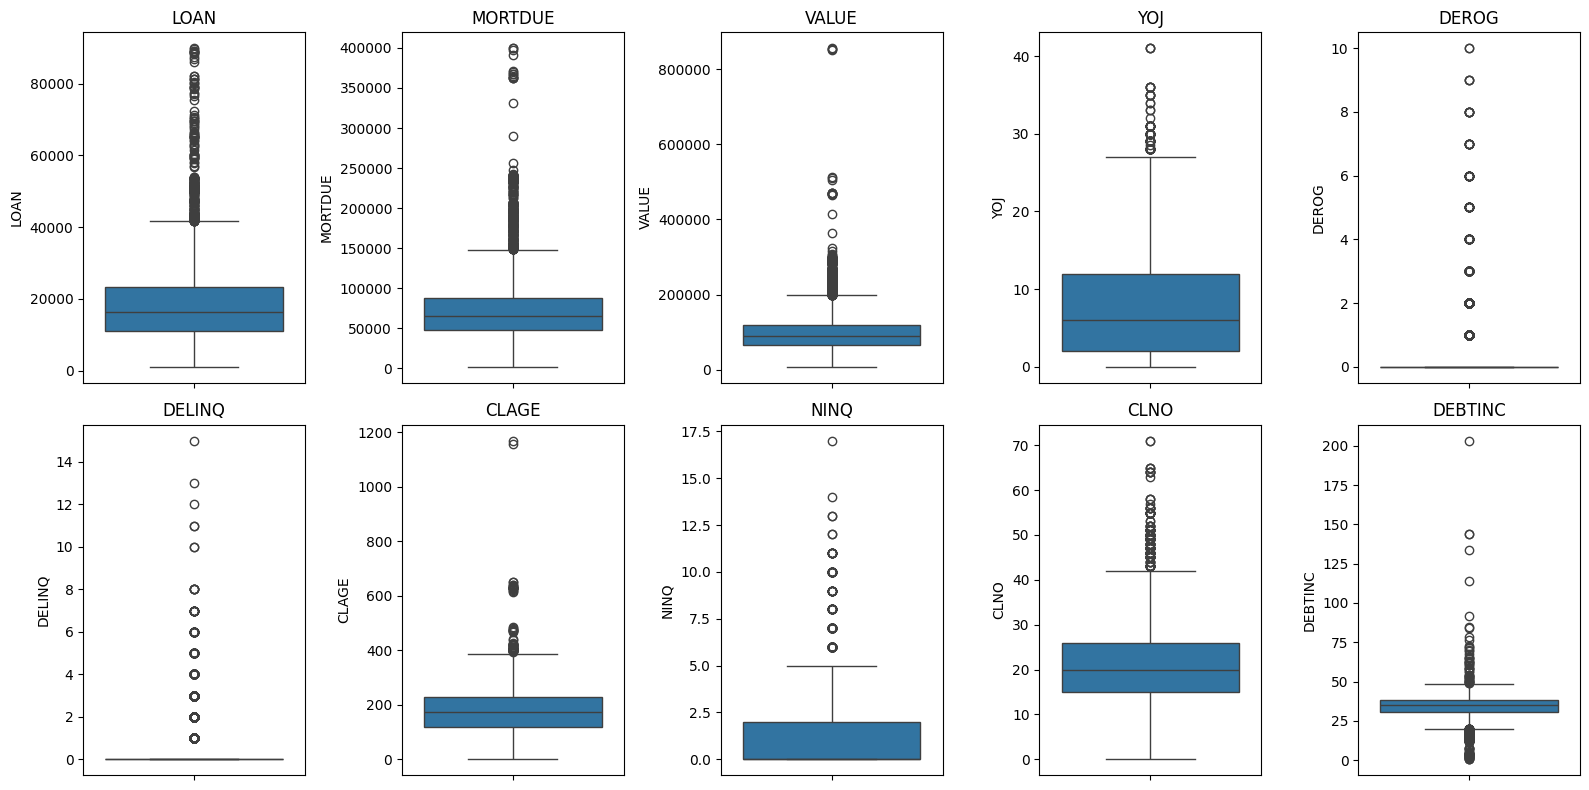

In [12]:
# Display box plots
num_cols = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
fig, axes = plt.subplots(2, 5, figsize=(16, 8))
axes_flat = axes.flatten()
for i, ax in enumerate(axes_flat):
    sns.boxplot(data=df[num_cols[i]], ax=ax)
    ax.set_title(num_cols[i])
plt.tight_layout()
plt.show()

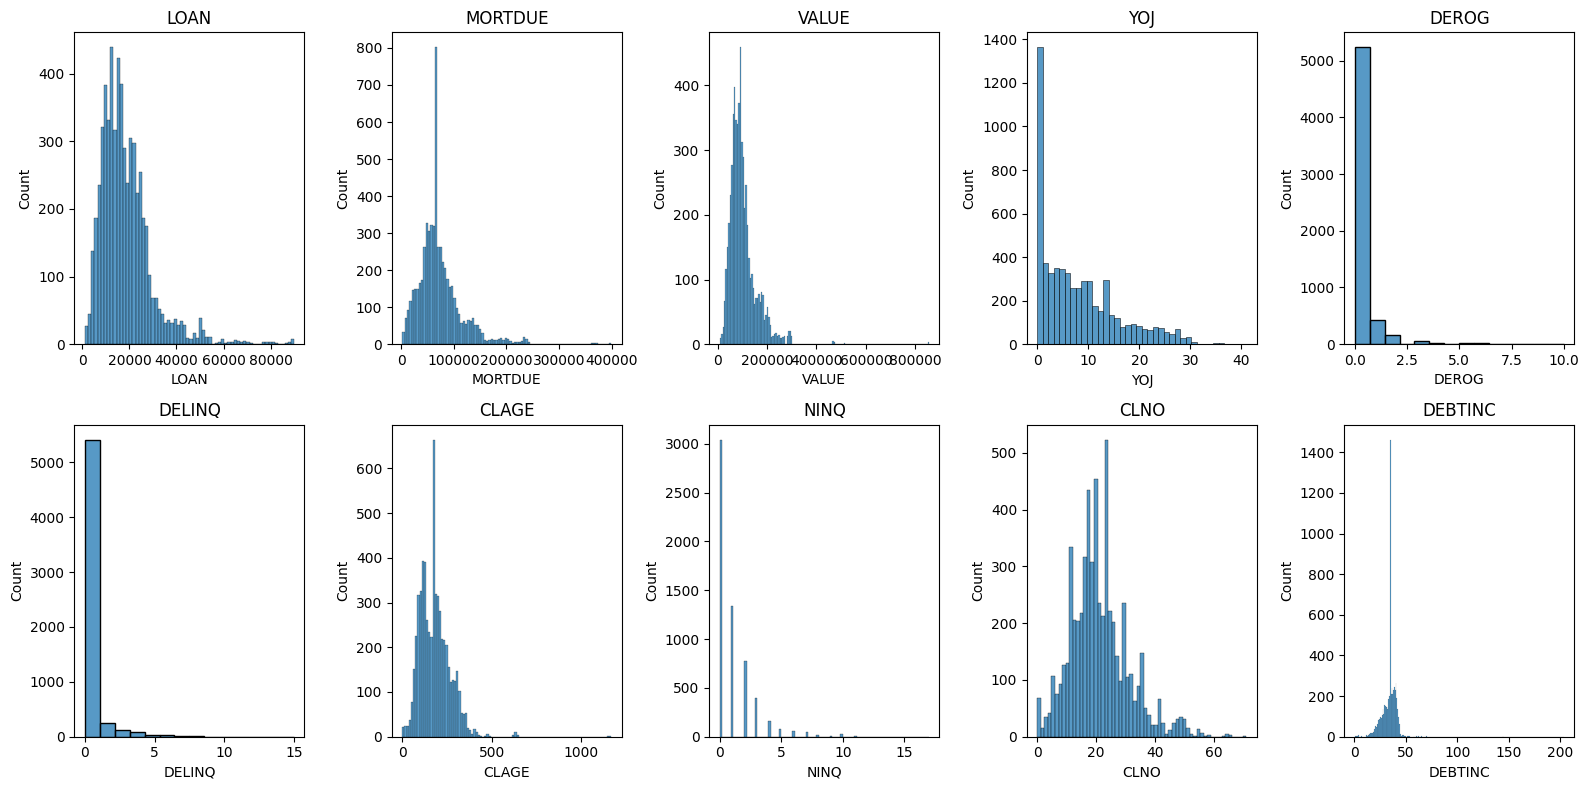

In [13]:
# Display box plots
num_cols = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
fig, axes = plt.subplots(2, 5, figsize=(16, 8))
axes_flat = axes.flatten()
for i, ax in enumerate(axes_flat):
    sns.histplot(data=df[num_cols[i]], ax=ax)
    ax.set_title(num_cols[i])
plt.tight_layout()
plt.show()

## Outlier Handling Strategy



| Column Name | Data Type | Recommended Action | Reason |
| :--- | :--- | :--- | :--- |
| **CLAGE** | Time (Months) | **Cap at 99th Percentile** | The max value is likely an error. Capping removes extreme errors. |
| **LOAN**<br>**MORTDUE**<br>**VALUE**<br>**DEBTINC**<br>**YOJ**<br>**CLNO** | Continuous / Monetary | **Log Transformation** | These generally have a long tail (skewed). Log transform compresses the range without removing data. |
| **DEROG**<br>**DELINQ**<br>**NINQ** | Risk Counts | **Keep As Is** | High values are rare but distinct risk signals. Log transform is not necessary for small integer counts. |


In [14]:
# Capping (Winsorization)
upper_limit_clage = df['CLAGE'].quantile(0.99)
df['CLAGE'] = df['CLAGE'].clip(upper=upper_limit_clage)

# Log Transformation
cols_log = ['YOJ', 'CLNO', 'LOAN', 'MORTDUE', 'VALUE', 'DEBTINC']
for col in cols_log:
    # Safety check: if min <= 0, use log1p instead to avoid errors
    if df[col].min() <= 0:
        df[col] = np.log1p(df[col])
    else:
        df[col] = np.log(df[col])

# One-Hot Encoding

In [15]:
df_encoded = pd.get_dummies(df, columns=['REASON', 'JOB'], drop_first=True)
print(df_encoded.columns)

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC', 'YOJ_MISSING', 'DEROG_MISSING',
       'DELINQ_MISSING', 'CLAGE_MISSING', 'NINQ_MISSING', 'CLNO_MISSING',
       'DEBTINC_MISSING', 'REASON_HomeImp', 'REASON_Unknown', 'JOB_Office',
       'JOB_Other', 'JOB_ProfExe', 'JOB_Sales', 'JOB_Self', 'JOB_Unknown'],
      dtype='object')


# Data Splitting

In [16]:
target_col = 'BAD'
X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print(f"Train shape: {X_train.shape}")
print(f"Test shape:  {X_test.shape}")

Train shape: (4768, 25)
Test shape:  (1192, 25)


# Scaling (Standardization)

In [17]:
scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Decision Tree

In [18]:
# Parameters for grid search
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced'] + [{0: 1, 1: w} for w in [1, 2, 3, 5, 10]]
}

model = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(
    model,
    param_grid,
    cv=10,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

print(f"Best parameters: {grid_search.best_params_}")
print(f"\nPerformance Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"F1-score: {f1_score(y_test, y_pred):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['REPAID', 'DEFAULT']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Export the best model
joblib.dump(best_model, './models/decision_tree_model.pkl')

Fitting 10 folds for each of 1568 candidates, totalling 15680 fits


Best parameters: {'class_weight': {0: 1, 1: 3}, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}

Performance Metrics:
Accuracy: 0.876
Precision: 0.689
Recall: 0.689
F1-score: 0.689
ROC-AUC: 0.790

Classification Report:
              precision    recall  f1-score   support

      REPAID       0.92      0.92      0.92       954
     DEFAULT       0.69      0.69      0.69       238

    accuracy                           0.88      1192
   macro avg       0.81      0.81      0.81      1192
weighted avg       0.88      0.88      0.88      1192


Confusion Matrix:
[[880  74]
 [ 74 164]]


['./models/decision_tree_model.pkl']

# Logistic Regression

In [19]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Predict
y_pred_log = log_reg.predict(X_test_scaled)
y_pred_proba_log = log_reg.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print(f"\nPerformance Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_log):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_log):.3f}")
print(f"F1-score: {f1_score(y_test, y_pred_log):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_log):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_log, target_names=['REPAID', 'DEFAULT']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_log)
print(cm)

# Export the model
joblib.dump(log_reg, './models/logistic_regression_model.pkl')


Performance Metrics:
Accuracy: 0.872
Precision: 0.735
Recall: 0.559
F1-score: 0.635
ROC-AUC: 0.881

Classification Report:
              precision    recall  f1-score   support

      REPAID       0.90      0.95      0.92       954
     DEFAULT       0.73      0.56      0.63       238

    accuracy                           0.87      1192
   macro avg       0.82      0.75      0.78      1192
weighted avg       0.86      0.87      0.86      1192


Confusion Matrix:
[[906  48]
 [105 133]]


['./models/logistic_regression_model.pkl']

# Support Vector Machine (SVM)

In [20]:
svm_model = SVC(kernel='rbf', random_state=42, probability=True)
svm_model.fit(X_train_scaled, y_train)

# Predict
y_pred_svm = svm_model.predict(X_test_scaled)
y_pred_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print(f"\nPerformance Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_svm):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_svm):.3f}")
print(f"F1-score: {f1_score(y_test, y_pred_svm):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_svm):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['REPAID', 'DEFAULT']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_svm)
print(cm)

# Export the model
joblib.dump(svm_model, './models/svm_model.pkl')


Performance Metrics:
Accuracy: 0.902
Precision: 0.838
Recall: 0.630
F1-score: 0.719
ROC-AUC: 0.912

Classification Report:
              precision    recall  f1-score   support

      REPAID       0.91      0.97      0.94       954
     DEFAULT       0.84      0.63      0.72       238

    accuracy                           0.90      1192
   macro avg       0.88      0.80      0.83      1192
weighted avg       0.90      0.90      0.90      1192


Confusion Matrix:
[[925  29]
 [ 88 150]]


['./models/svm_model.pkl']

# Conclusion

## Created Models
* Decision Tree
* Logistic Regression
* SVM

We built the three models listed above following the methodology used in the research paper.  
As a result, while the research paper reported that the Decision Tree achieved the highest accuracy on their dataset, in our experiment, the SVM showed the best performance on the current dataset.

---

## Interpretation
From these results, it is possible that the decision boundaries in the current dataset were smoother compared to those in the original dataset.  
Additionally, because the current dataset contains more continuous variables than the original one, the SVM may have been better able to capture the distances between data points, which could have contributed to the improved accuracy.

---

## Performance Comparison
* **Accuracy on the original research paper's dataset (UCI):** 78%
* **Accuracy on this dataset (HMEQ):** 88%

### Discussion on the Performance Discrepancy
The observed performance gap can be attributed to distinct characteristics inherent in each dataset. Specifically, the presence of missing values acts as a key differentiator:

* **HMEQ Dataset (Current Dataset):**  
  The dataset contains missing values, which actually carry significant information.  
  Specifically, rows with missing **DEBTINC** (Debt-to-Income ratio) show an exceptionally high default rate of over 60% (likely due to reasons such as the applicant's inability to provide proof of income).  
  In this case, the "missingness itself" serves as a powerful predictor for the model.

* **UCI Dataset (Reference Dataset):**  
  Since this dataset is well-curated and contains no missing values, the model cannot leverage such "hidden signals" embedded in data absence.